# Show time distribution
=======================================



- Author Sylvie Dagoret-Campagne
- Creation date Friday 5th 2016


## Import packages
-------------------------

In [92]:
%config InlineBackend.rc = {}
import matplotlib
matplotlib.rc_file("../templates/matplotlibrc")


%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from astropy.modeling import models
from astropy import units as u
from astropy import nddata
from astropy.io import fits
from astropy.table import Table

import ccdproc
print 'ccdproc version',ccdproc.__version__

from astropy.modeling import models

ccdproc version 1.0.1


In [93]:
from astropy.time import Time, TimeDelta,TimezoneInfo

In [94]:
def smooth(x,window_len=11,window='hanning'):
    """
    smooth the data using a window with requested size.     
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
     (with the window size) in both ends so that transient parts are minimized
     in the begining and end part of the output signal.     
     input:
     x: the input signal 
     window_len: the dimension of the smoothing window; should be an odd integer
     window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman
     flat window will produce a moving average smoothing.

     output:
        the smoothed signal         
        example:
 
         t=linspace(-2,2,0.1)
         x=sin(t)+randn(len(t))*0.1
         y=smooth(x)
         
         see also: 
           
         numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
           scipy.signal.lfilter
    
           TODO: the window parameter could be the window itself if an array instead of a string
           NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
       """ 
      
    if x.ndim != 1:
        raise ValueError, "smooth only accepts 1 dimension arrays."
 
    if x.size < window_len:
        raise ValueError, "Input vector needs to be bigger than window size."
 
    if window_len<3:
        return x
   
    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError, "Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'"
       
  
    s=np.r_[x[window_len-1:0:-1],x,x[-1:-window_len:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')
     
    y=np.convolve(w/w.sum(),s,mode='valid')
    return y    

In [95]:
from scipy import stats 
from scipy import ndimage
import os
from datetime import datetime, timedelta

In [96]:
now=datetime.utcnow()  # choose UTC time
datestr=str(now)
print 'standard date format for the analysis :',datestr
#  want the following format '2016-05-10T11:55:27.267'
date_of_analysis=now.strftime('%Y-%m-%dT%H:%M:%S')
print 'fits date format for the analysis : ',date_of_analysis

standard date format for the analysis : 2016-07-19 21:29:46.002349
fits date format for the analysis :  2016-07-19T21:29:46


In [97]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

## Few definitions
-----------------------

- file index
- object name
- filename
- path

### Night 2016/05/11

In [98]:
# definition for the series of images
#run=1
#FactorPredToData=2.3e14
#fileindex_start=103;  # file number
#fileindex_stop=112;
#fileindexes=np.arange(fileindex_start,fileindex_stop+1)
#info='obj HD158485_grat_, 05/11, Nimg='+str(fileindexes.shape[0]) +', expo=5s, am=1.1' 
#infofig='hd158485_grat_0511_run_'+str(run)+'_'+str(fileindex_start)+'-'+str(fileindex_stop)
#infotab='hd158485_grat_0511_run_'+str(run)+'_'+str(fileindex_start)+'-'+str(fileindex_stop)
#path_spectrum=path='../MyReduction_2016_05_11/HD158485_grat'+'_spectra'   # path where is the spectra

In [99]:
# definition for the series of images
#run=2
#FactorPredToData=2.3e14
#fileindex_start=52;  # file number
#fileindex_stop=71;
#fileindexes=np.arange(fileindex_start,fileindex_stop+1)
#info='obj HD158485_grat_, 05/11, Nimg='+str(fileindexes.shape[0]) +', expo=5s, am=1.2' 
#infofig='hd158485_grat_0511_run_'+str(run)+'_'+str(fileindex_start)+'-'+str(fileindex_stop)
#infotab='hd158485_grat_0511_run_'+str(run)+'_'+str(fileindex_start)+'-'+str(fileindex_stop)
#path_spectrum=path='../MyReduction_2016_05_11/HD158485_grat'+'_spectra'   # path where is the spectra

In [100]:
# definition for the series of images
#run=3
#FactorPredToData=2.3e14
#fileindex_start=22;  # file number
#fileindex_stop=31;
#fileindexes=np.arange(fileindex_start,fileindex_stop+1)
#info='obj HD158485_grat_, 05/11, Nimg='+str(fileindexes.shape[0]) +', expo=5s, am=1.43' 
#infofig='hd158485_grat_0511_run_'+str(run)+'_'+str(fileindex_start)+'-'+str(fileindex_stop)
#infotab='hd158485_grat_0511_run_'+str(run)+'_'+str(fileindex_start)+'-'+str(fileindex_stop)
#path_spectrum=path='../MyReduction_2016_05_11/HD158485_grat'+'_spectra'   # path where is the spectra

In [101]:
# definition for the series of images
run=4
FactorPredToData=2.3e14
fileindex_start=7;  # file number
fileindex_stop=16;
fileindexes=np.arange(fileindex_start,fileindex_stop+1)
info='obj HD158485_grat_, 05/11, Nimg='+str(fileindexes.shape[0]) +', expo=5s, am=1.77' 
infofig='hd158485_grat_0511_run_'+str(run)+'_'+str(fileindex_start)+'_'+str(fileindex_stop)
infotab='hd158485_grat_0511_run_'+str(run)+'_'+str(fileindex_start)+'-'+str(fileindex_stop)
path_spectrum=path='../MyReduction_2016_05_11/HD158485_grat'+'_spectra'   # path where is the spectra

### Night 2016/05/09

In [102]:
# definition for the series of images
#run=5
#FactorPredToData=2.3e14
#fileindex_start=2;  # file number
#fileindex_stop=25;
#fileindexes=np.arange(fileindex_start,fileindex_stop+1)
#info='obj HD158485_grat_, 05/09, Nimg='+str(fileindexes.shape[0]) +', expo=1.5s, am=1.1' 
#infofig='hd158485_grat_0509_run_'+str(run)+'_'+str(fileindex_start)+'_'+str(fileindex_stop)
#infotab='hd158485_grat_0509_run_'+str(run)+'_'+str(fileindex_start)+'-'+str(fileindex_stop)
#path_spectrum=path='../MyReduction_2016_05_09/HD158485_grat'+'_spectra'   # path where is the spectra

### Night 2016/05/10

In [103]:
# definition for the series of images
#run=6
#FactorPredToData=2.3e14
#fileindex_start=2;  # must remove the first image because goes not with the others
#fileindex_stop=13;
#fileindexes=np.arange(fileindex_start,fileindex_stop+1)
#info='obj HD158485_grat_, 05/10, Nimg='+str(fileindexes.shape[0]) +', expo=1.5-5s, am=1.1' 
#infofig='hd158485_grat_0510_run_'+str(run)+'_'+str(fileindex_start)+'_'+str(fileindex_stop)
#infotab='hd158485_grat_0510_run_'+str(run)+'_'+str(fileindex_start)+'-'+str(fileindex_stop)
#path_spectrum=path='../MyReduction_2016_05_10/HD158485_grat'+'_spectra'   # path where is the spectra

In [104]:
object_name='HD158485_grat_' # object name

In [105]:

path='../MyReduction_2016_05_11'   # path of the table


In [106]:
tablefile_HD158485_PSF_with_AM='HD158485_grat_1-132_TablePSF_night20160511_withAM.fits'

In [107]:
fullfilename=os.path.join(path,tablefile_HD158485_PSF_with_AM)

### A) Open the table file

- open and read each of the fits file
- fill the list booked above


In [108]:
t = Table.read(fullfilename)

In [109]:
t.show_in_notebook()

num,file,time,exposure,nbstars,prfx,pfry,sig_prfx,sig_prfy,sigmax,sigmay,azimuth,altitude,airmass
,,,,,,,,,,,deg,deg,
1,AssScImHD158485_grat_1.fits,2016-05-12T04:08:27.322,5.0,1,4.47415632464,4.32646900741,0.0,0.0,4.22360357046,4.08418674299,38.317046414,34.0317973678,1.78682177288
2,AssScImHD158485_grat_2.fits,2016-05-12T04:10:10.602,5.0,5,4.23915877347,4.09248732084,0.392718231946,0.18464392513,4.00176588215,3.86330803087,38.3781306161,34.2506080516,1.77678688395
3,AssScImHD158485_grat_3.fits,2016-05-12T04:10:20.458,5.0,21,3.76020655028,3.81432116694,0.235852244067,0.767497075115,3.54963498347,3.60071918159,38.3838874334,34.271504474,1.77583579663
4,AssScImHD158485_grat_4.fits,2016-05-12T04:10:29.432,5.0,21,3.56680321661,3.96483104307,0.181167115677,0.648766625551,3.36706223648,3.74280050466,38.3891180689,34.2905332072,1.77497080661
5,AssScImHD158485_grat_5.fits,2016-05-12T04:10:38.586,5.0,10,3.54780685321,3.54182907249,0.394432864272,0.769873402452,3.34912966943,3.34348664443,38.3944427983,34.3099458746,1.77408943351
6,AssScImHD158485_grat_6.fits,2016-05-12T04:10:47.541,5.0,23,3.5644327671,3.49984527018,0.199997271512,0.77663355496,3.36482453215,3.30385393505,38.39964119,34.3289387283,1.77322816438
7,AssScImHD158485_grat_7.fits,2016-05-12T04:10:56.526,5.0,33,3.40986449559,3.42051094206,0.21440035444,0.74200994629,3.21891208384,3.2289623293,38.4048464703,34.3479973927,1.7723649468
8,AssScImHD158485_grat_8.fits,2016-05-12T04:11:05.546,5.0,15,3.31082909982,3.41278053444,0.287048747871,0.315149038754,3.12542267023,3.22166482451,38.4100614141,34.3671324928,1.77149930943
9,AssScImHD158485_grat_9.fits,2016-05-12T04:11:14.644,5.0,20,3.66129988733,3.56658136927,0.372296084714,0.601672154467,3.45626709364,3.36685281259,38.4153106745,34.3864352857,1.77062714222


In [110]:
all_airmass=t['airmass']
all_num=t['num']
all_times=Time(t['time'])

In [111]:
selected_time=all_times[np.where(np.logical_and(all_num>=fileindex_start, all_num<=fileindex_stop))]
selected_num=all_num[np.where(np.logical_and(all_num>=fileindex_start, all_num<=fileindex_stop))]
selected_airmass=all_airmass[np.where(np.logical_and(all_num>=fileindex_start, all_num<=fileindex_stop))]

In [112]:
selected_time

<Time object: scale='utc' format='isot' value=['2016-05-12T04:10:56.526' '2016-05-12T04:11:05.546'
 '2016-05-12T04:11:14.644' '2016-05-12T04:11:23.668'
 '2016-05-12T04:11:32.661' '2016-05-12T04:11:41.765'
 '2016-05-12T04:11:50.838' '2016-05-12T04:11:59.898'
 '2016-05-12T04:12:08.975' '2016-05-12T04:12:18.028']>

In [113]:
selected_airmass

1.7723649468
1.77149930943
1.77062714222
1.76976301592
1.76890279527
1.76803290871
1.76716693574
1.76630315025
1.76543869151
1.76457746194


In [114]:
timediff=selected_time-selected_time[0]

In [115]:
timediff.sec


array([  0.   ,   9.02 ,  18.118,  27.142,  36.135,  45.239,  54.312,
        63.372,  72.449,  81.502])

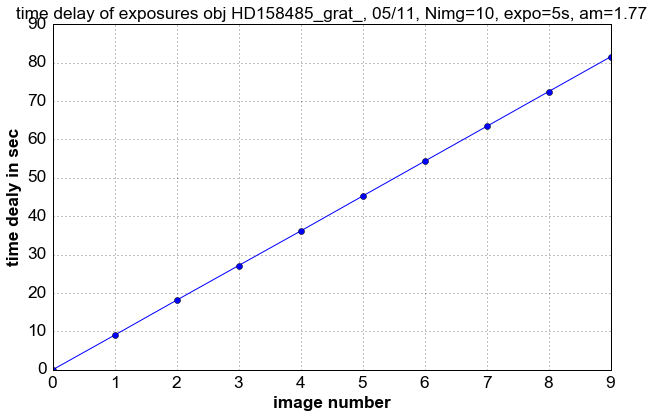

In [116]:
figname='time_diff'+infofig+'.pdf'
plt.figure(figsize=(10.,6.))
plt.plot(timediff.sec,'o-',color='b')
title='time delay of exposures '+info
plt.title(title)
plt.xlabel('image number')
plt.ylabel('time dealy in sec')
plt.savefig(figname)

### Smooth the predicted response to simulate finite wavelength resolution

- use the smoothing function given above and copied form internet

## C) combine the experimental spectra 

- cut the prediction to get arrays of same size (same number of wavelength bins)

#### First,  store each predicted spectra in a 2D array

#### Second, Combine the preduction by calculating the average

### Comparison of predicted spectrum and experimental spectrum

#### need to force the data and the prediction to be of the same size

- ressample the experimental data with the binning of the predicted spectrum by using
the interpolep function of numpy

#### check the result of the interpolation

#### Cut to remove zeros in the division


- select wavelengthes larger than 400 nm

#### Save in a fits file

### Ratio RMS To Average

#### Save in fits file

## Aerosols

    spectra_list = []      # list of experimental spectra
    wavelength_list = []   # wavelength table of experimental spectra
    obspred_list = []      # list of predicted spectra
    wavelengthobspred_list = []  # list of wavelength for predicted spectra
    atm_list= []